1. Импорт библиотек

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, 
                            confusion_matrix, 
                            ConfusionMatrixDisplay)
from sklearn.preprocessing import StandardScaler
import pandas as pd
import cv2
from PIL import Image, ImageDraw, ImageFont
import os

2.Генерация данных

Тип данных mnist.data: <class 'pandas.core.frame.DataFrame'>
Форма исходных данных: (70000, 784)


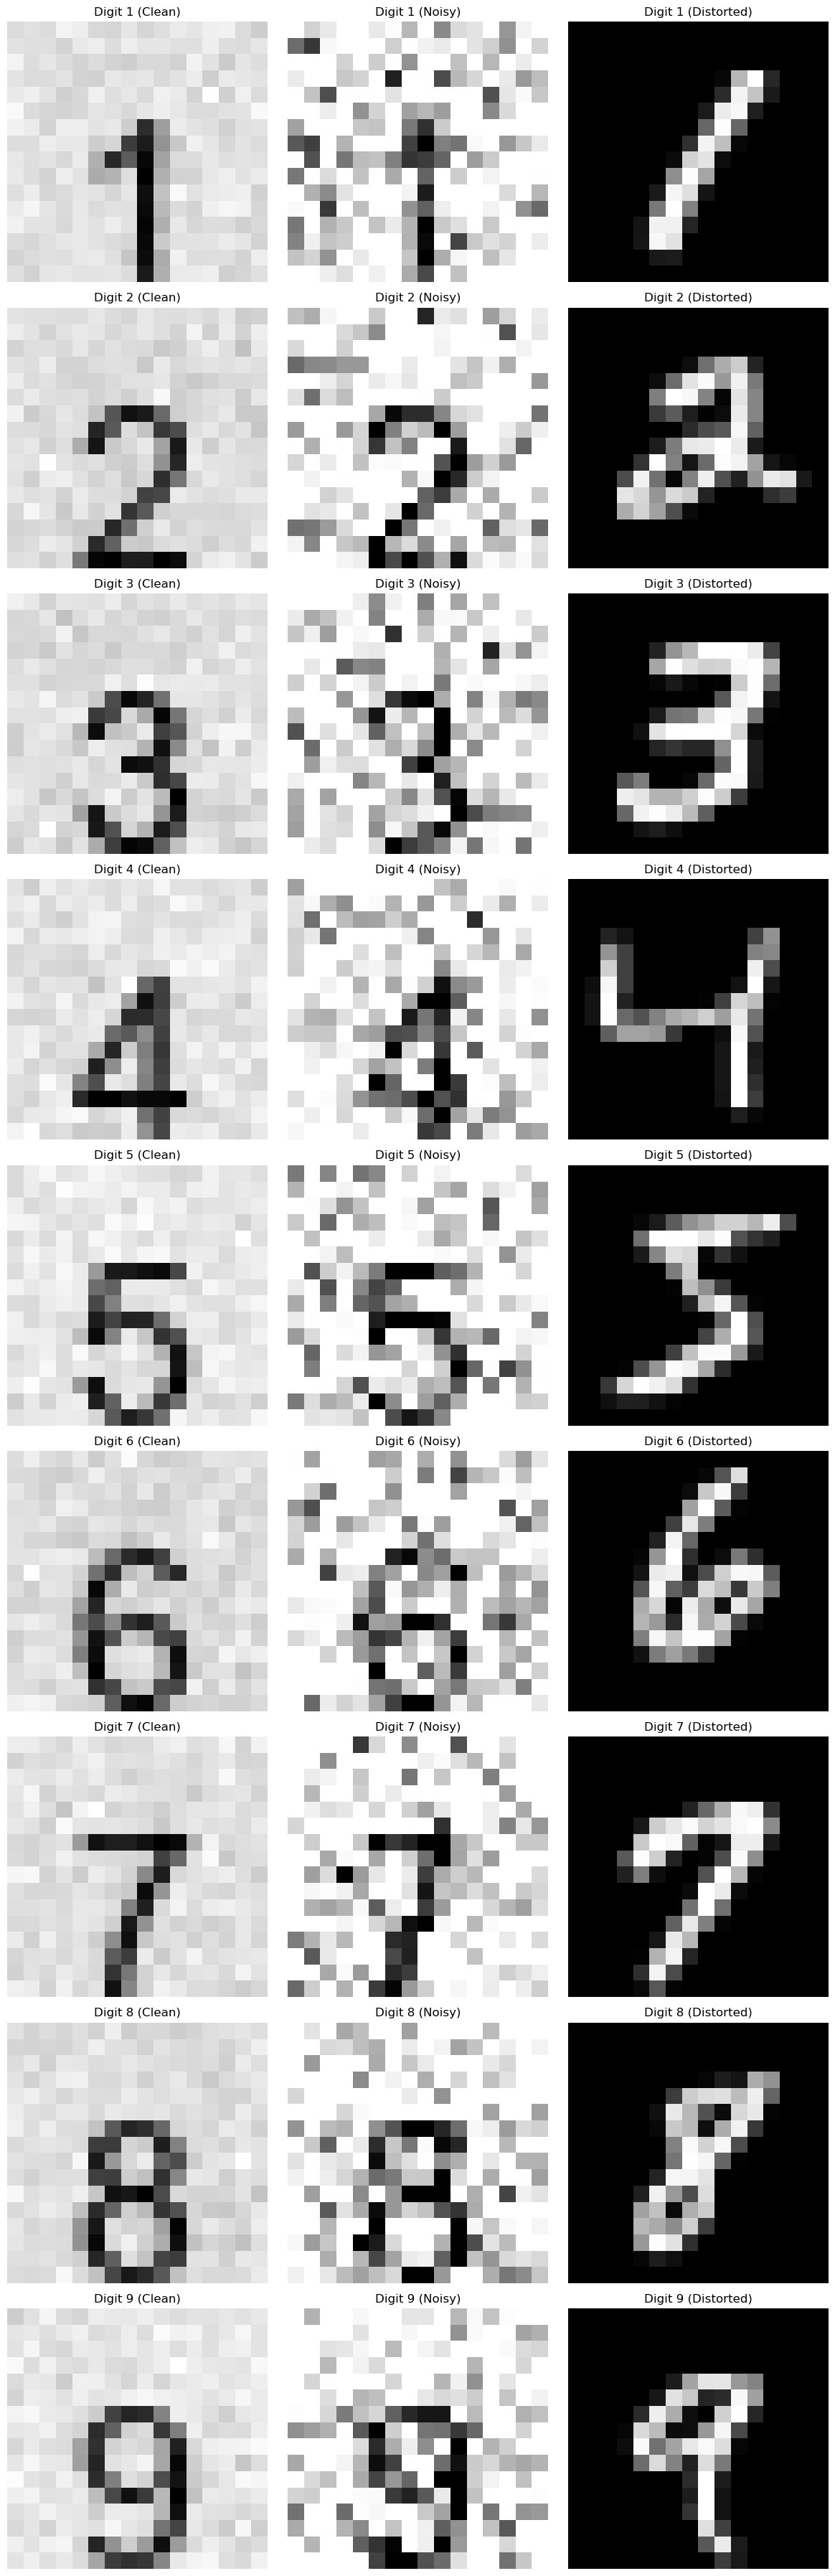

In [26]:
# Параметры генерации
IMG_SIZE = 16
NUM_SAMPLES = 1667  # на каждый тип
DIGITS = list(range(1, 10))

# Генератор эталонных изображений
def generate_clean_digit(d):
    img = Image.new('L', (IMG_SIZE, IMG_SIZE), 255)
    draw = ImageDraw.Draw(img)
    
    try: 
        font = ImageFont.truetype("arial.ttf", 14)
    except: 
        font = ImageFont.load_default()
    
    # Исправление для новых версий Pillow
    bbox = draw.textbbox((0, 0), str(d), font=font)  # <-- Основное исправление
    w = bbox[2] - bbox[0]
    h = bbox[3] - bbox[1]
    
    draw.text(((IMG_SIZE-w)//2, (IMG_SIZE-h)//2), 
             str(d), font=font, fill=0)
    
    return np.array(img)/255.0


# Добавление шума
def add_noise(img, intensity=0.3):
    noise = np.random.normal(0, intensity, img.shape)
    return np.clip(img + noise, 0, 1)

# Загрузка рукописных цифр (MNIST)
mnist = fetch_openml('mnist_784', version=1, parser='auto')

# Исправление ошибки: преобразование DataFrame в numpy array
X_mnist = mnist.data.to_numpy().reshape(-1, 28, 28).astype('float32')/255  # <-- Основное исправление
y_mnist = mnist.target.astype('int')

# Дополнительные проверки (рекомендуется добавить)
print(f"Тип данных mnist.data: {type(mnist.data)}")  # Должен быть DataFrame
print(f"Форма исходных данных: {mnist.data.shape}")  # Должно быть (70000, 784)

X_mnist = np.array([cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
                   for img in X_mnist])

# Фильтрация данных
mask = (y_mnist >= 1) & (y_mnist <= 9)
X_distorted = X_mnist[mask].reshape(-1, IMG_SIZE**2)
y_distorted = y_mnist[mask]

# Сборка датасета
data, labels, types = [], [], []

for d in DIGITS:
    # Чистые цифры
    base_img = generate_clean_digit(d)
    clean_imgs = np.array([base_img + np.random.normal(0, 0.05, (IMG_SIZE, IMG_SIZE)) 
                          for _ in range(NUM_SAMPLES)])
    
    # Зашумленные цифры
    noisy_imgs = np.array([add_noise(base_img) 
                          for _ in range(NUM_SAMPLES)])
    
    # Искаженные цифры
    distorted_idx = np.where(y_distorted == d)[0][:NUM_SAMPLES]
    
    # Объединение данных
    data.extend([clean_imgs.reshape(-1, IMG_SIZE**2), 
                noisy_imgs.reshape(-1, IMG_SIZE**2), 
                X_distorted[distorted_idx]])
    labels.extend([d]*3*NUM_SAMPLES)
    types.extend([0]*NUM_SAMPLES + [1]*NUM_SAMPLES + [2]*NUM_SAMPLES)

X = np.vstack(data)
y = np.array(labels)
types = np.array(types)

# Визуализация примеров
plt.figure(figsize=(12, 36))
for i, d in enumerate(DIGITS):
    for j, t in enumerate(['Clean', 'Noisy', 'Distorted']):
        idx = np.where((y == d) & (types == j))[0][0]
        plt.subplot(9, 3, i*3 + j + 1)
        plt.imshow(X[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        plt.title(f'Digit {d} ({t})')
        plt.axis('off')
plt.tight_layout()
plt.savefig('samples.png')
plt.show()

3. Предобработка данных

In [27]:
# Нормализация
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение данных
X_train, X_test, y_train, y_test, types_train, types_test = train_test_split(
    X_scaled, y, types, test_size=0.3, stratify=y, random_state=42)

4. Обучение модели

In [28]:
model = RandomForestClassifier(n_estimators=100, 
                              random_state=42,
                              n_jobs=-1)
model.fit(X_train, y_train)

# Прогнозирование
y_pred = model.predict(X_test)

5. Анализ результатов

Accuracy
Самым простым способом оценить качество модели является Accuracy или точность, которая отражает долю правильно спрогнозированных классов среди всех образцов


Precision
Характеризует долю правильно предсказанных положительных классов среди всех образцов, которые модель спрогнозировала как положительный класс


Recall (TPR)
Ещё известное как True Positive Rate, отражает долю правильно предсказанных положительных классов среди всех реальных положительных образцов


F1-score
Представляет собой гармоническое среднее между Precision и Recall, обеспечивая между ними баланс, что особенно полезно при неравномерном распределении классов. Использование данной метрики позволяет лучше выбрать модель, которая не только точно классифицирует злокачественные случаи, но и минимизирует количество пропущенных злокачественных опухолей.


Микро-усреднение (micro-averaging) является эквивалентом accuracy и подходит при сбалансированных классах. Элементы consufion matrix усредняются между бинарными прогнозами для каждого класса, после чего метрики рассчитываются на полученной матрице.



Взвешенное усреднение (weighted averaging) рассчитывается как взвешенное среднее и также применяется в случае дисбаланса классов, но только когда важность класса учитывается в зависимости от количества объектов с таким классом, то есть когда важны наибольшие классы. При таком подходе важность каждого класса учитывается с присвоением им весов. Вес класса w_k может устанавливаться по-разному, например, как доля примеров этого класса в обучающей выборке

              precision    recall  f1-score       support
1              0.988072  0.994000  0.991027   1500.000000
2              0.977513  0.985333  0.981408   1500.000000
3              0.981132  0.970667  0.975871   1500.000000
4              0.980172  0.988008  0.984074   1501.000000
5              0.978175  0.985343  0.981746   1501.000000
6              0.987359  0.989333  0.988345   1500.000000
7              0.987952  0.983344  0.985643   1501.000000
8              0.980445  0.969333  0.974858   1500.000000
9              0.978567  0.974000  0.976278   1500.000000
accuracy       0.982152  0.982152  0.982152      0.982152
macro avg      0.982154  0.982151  0.982139  13503.000000
weighted avg   0.982154  0.982152  0.982139  13503.000000


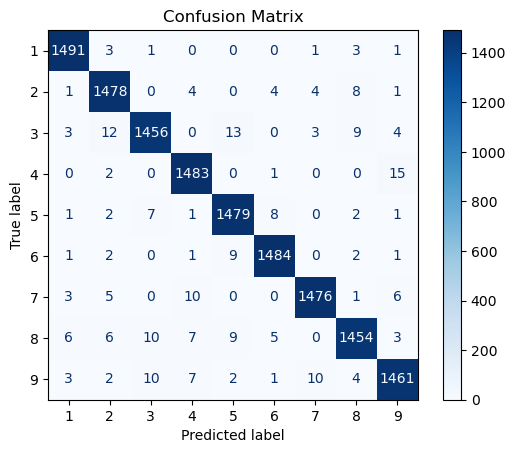

In [29]:
# Текстовый отчет
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=DIGITS)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

6. корреляционный анализ

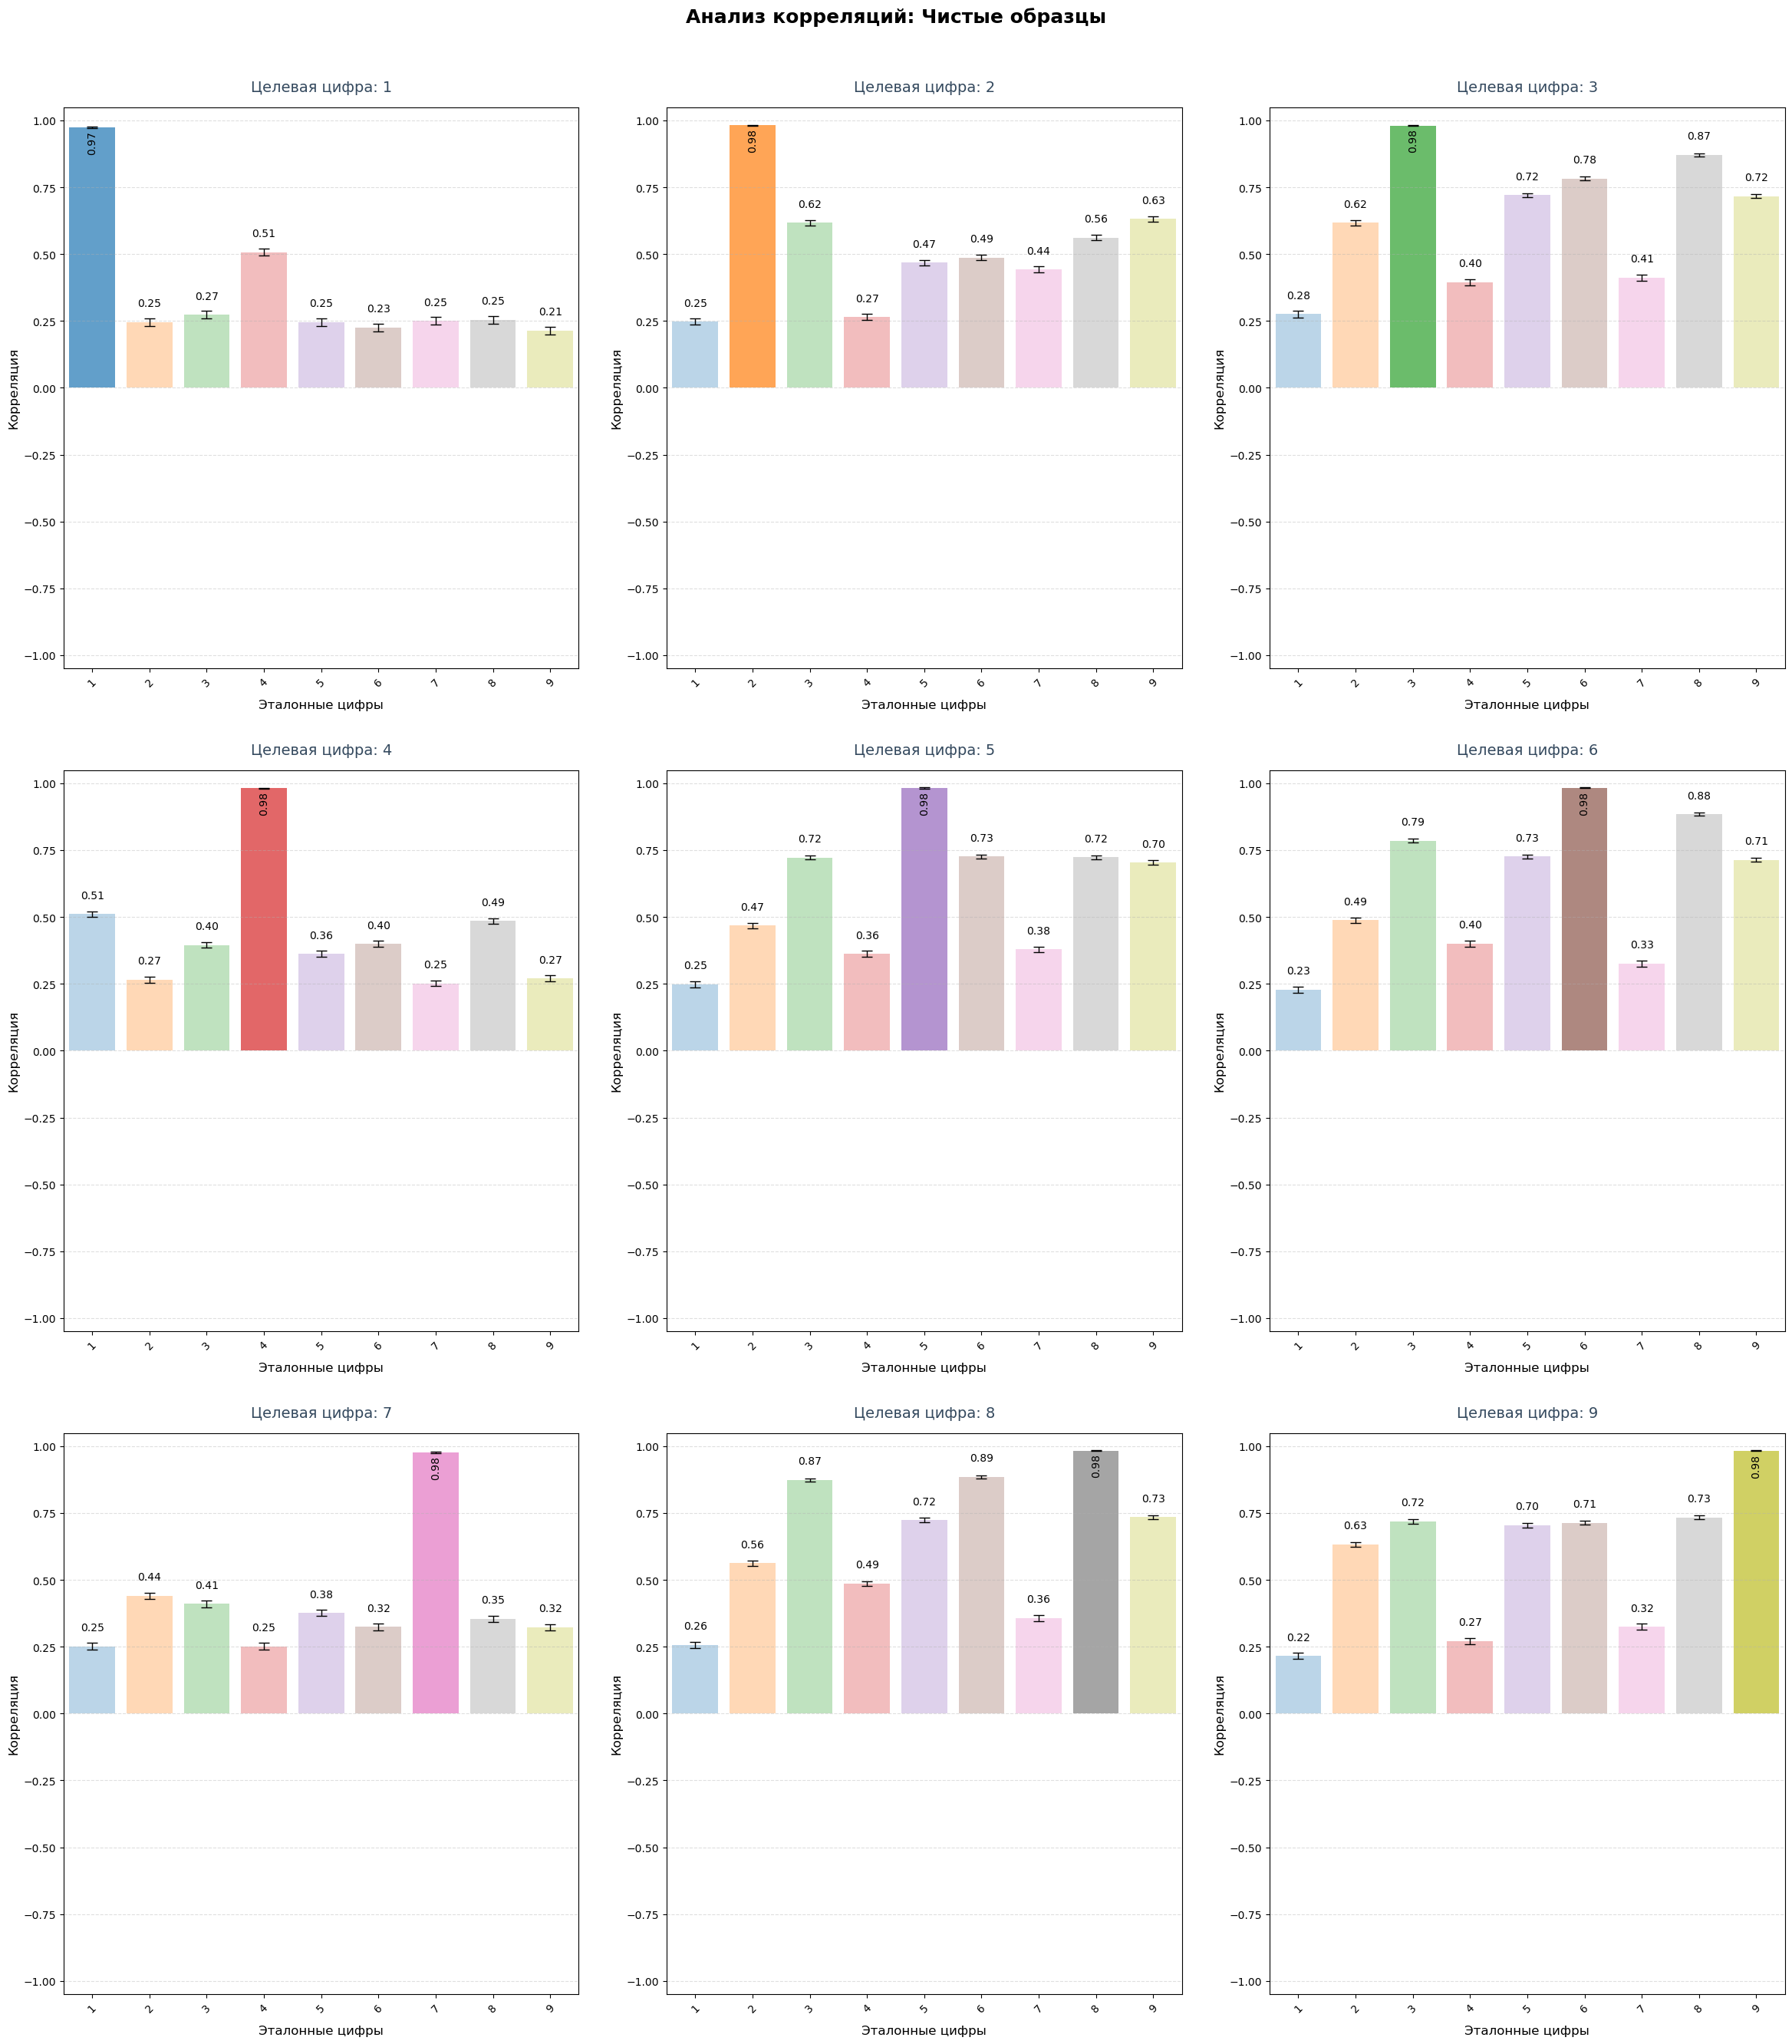

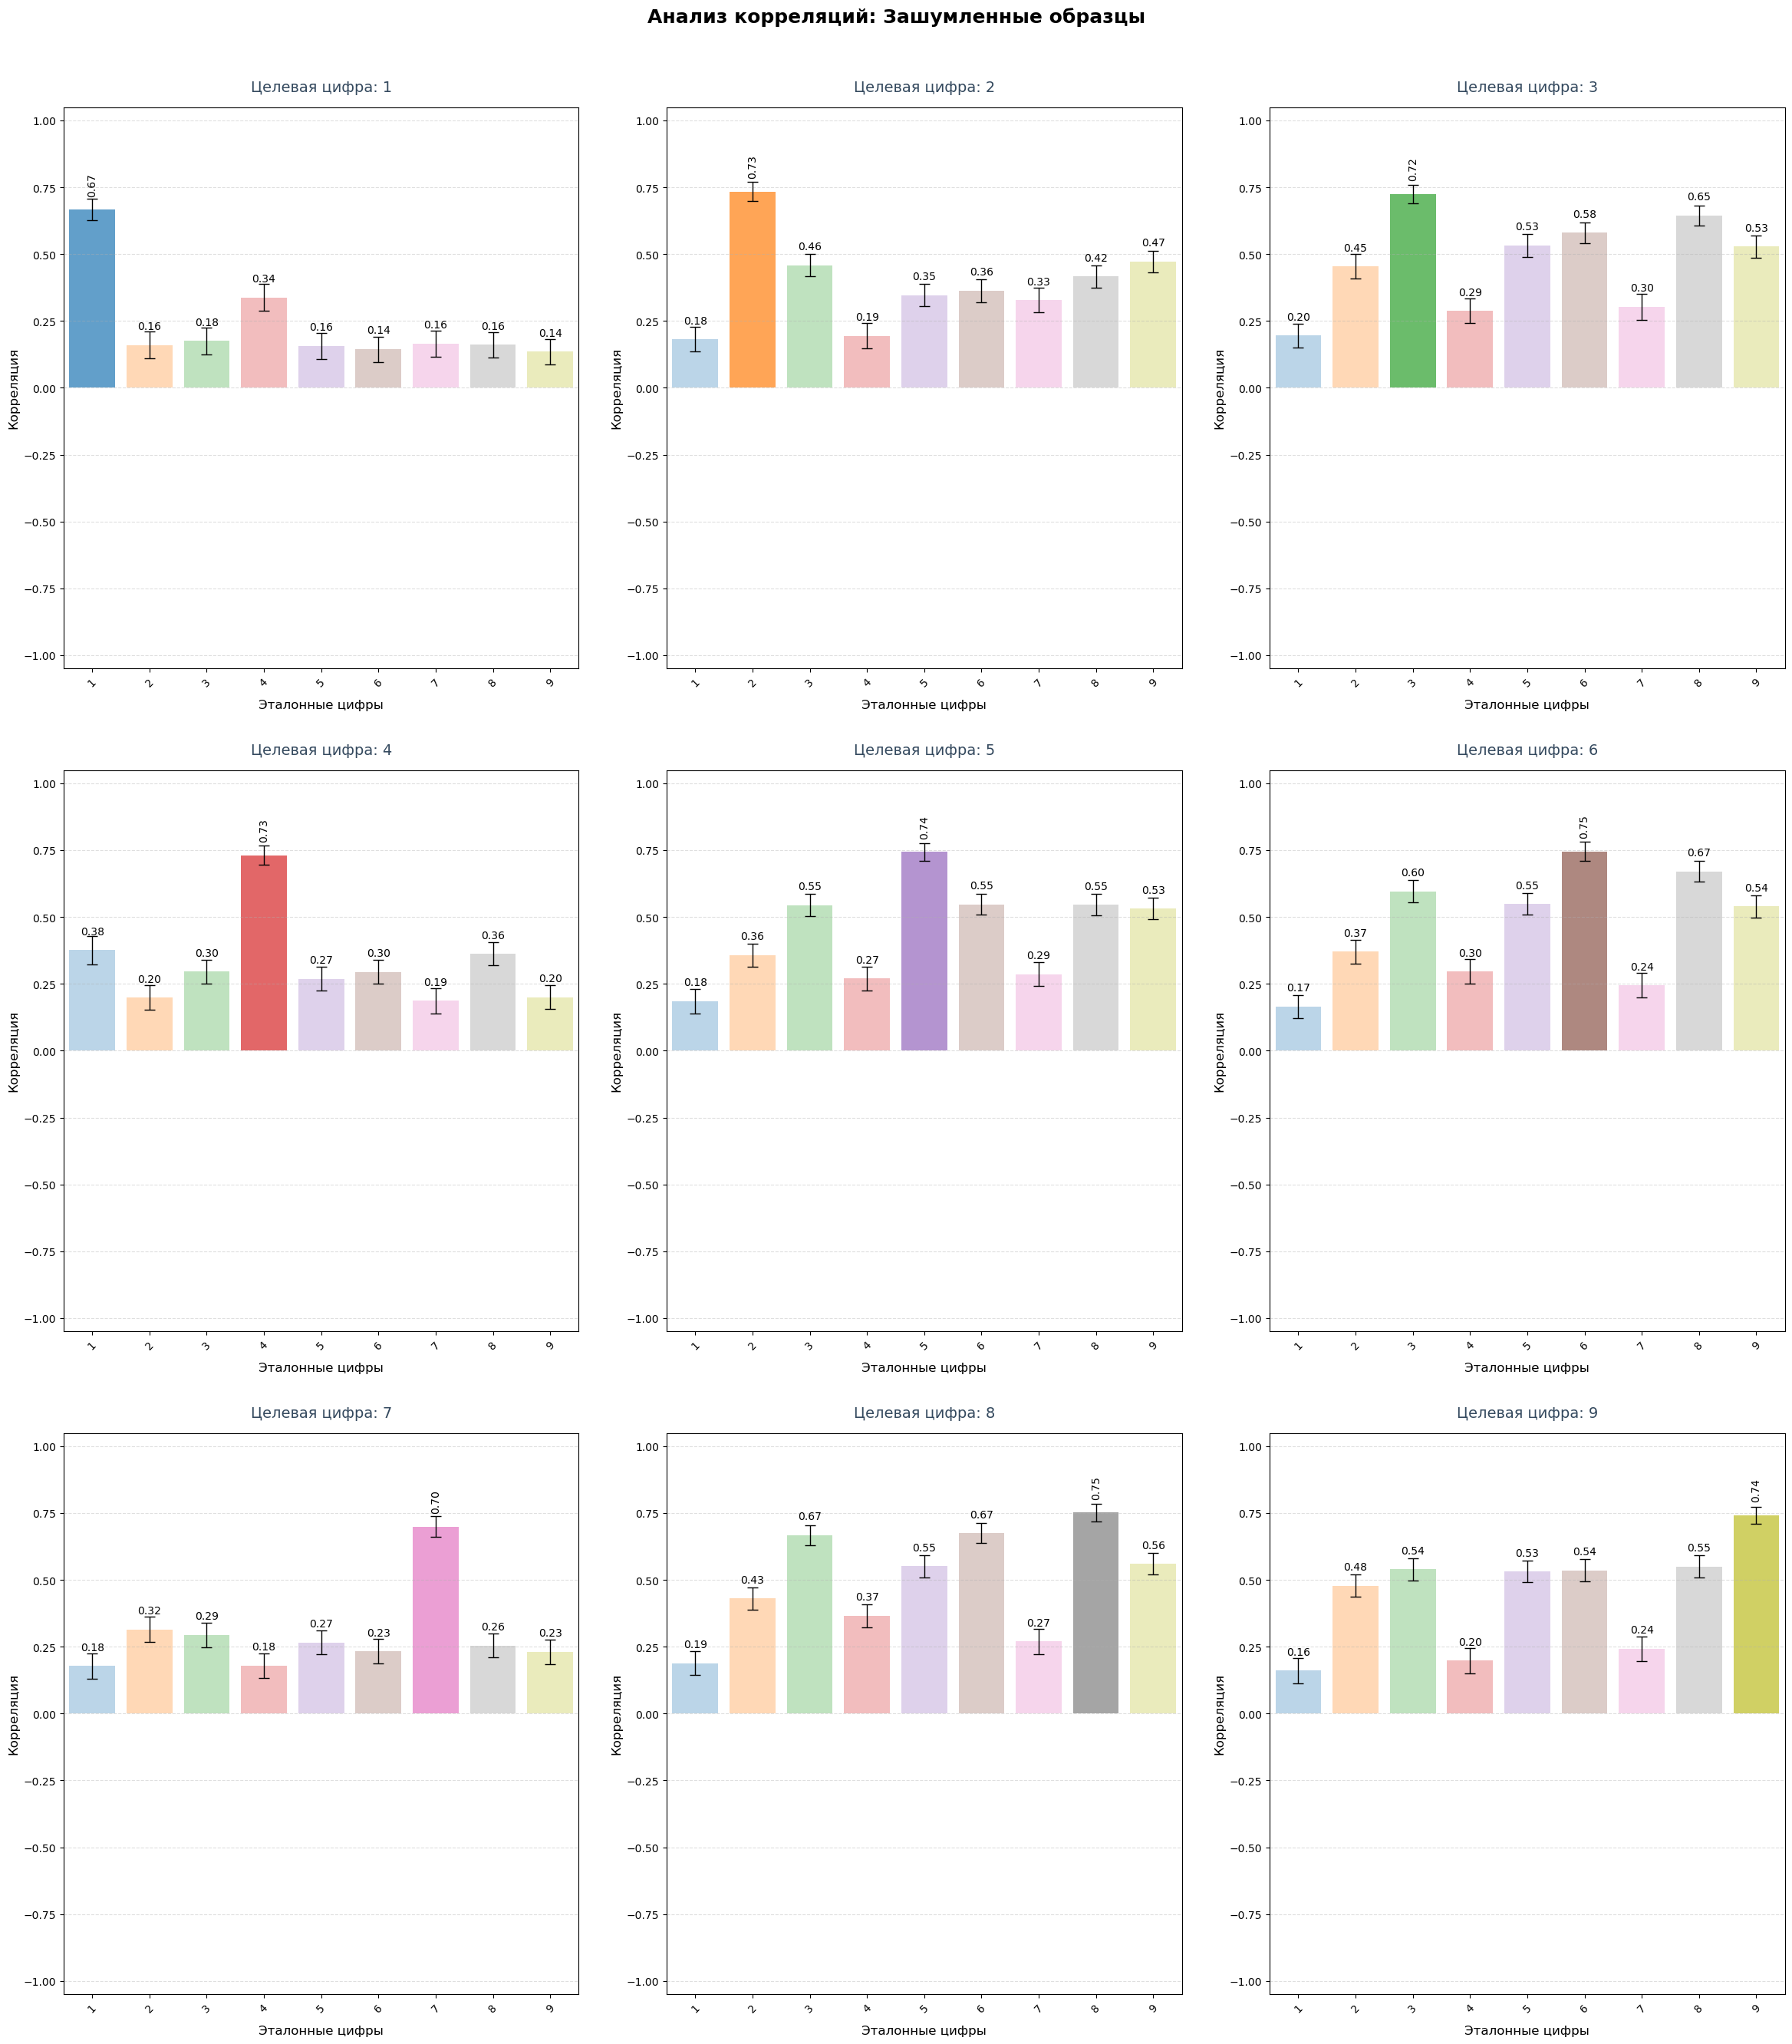

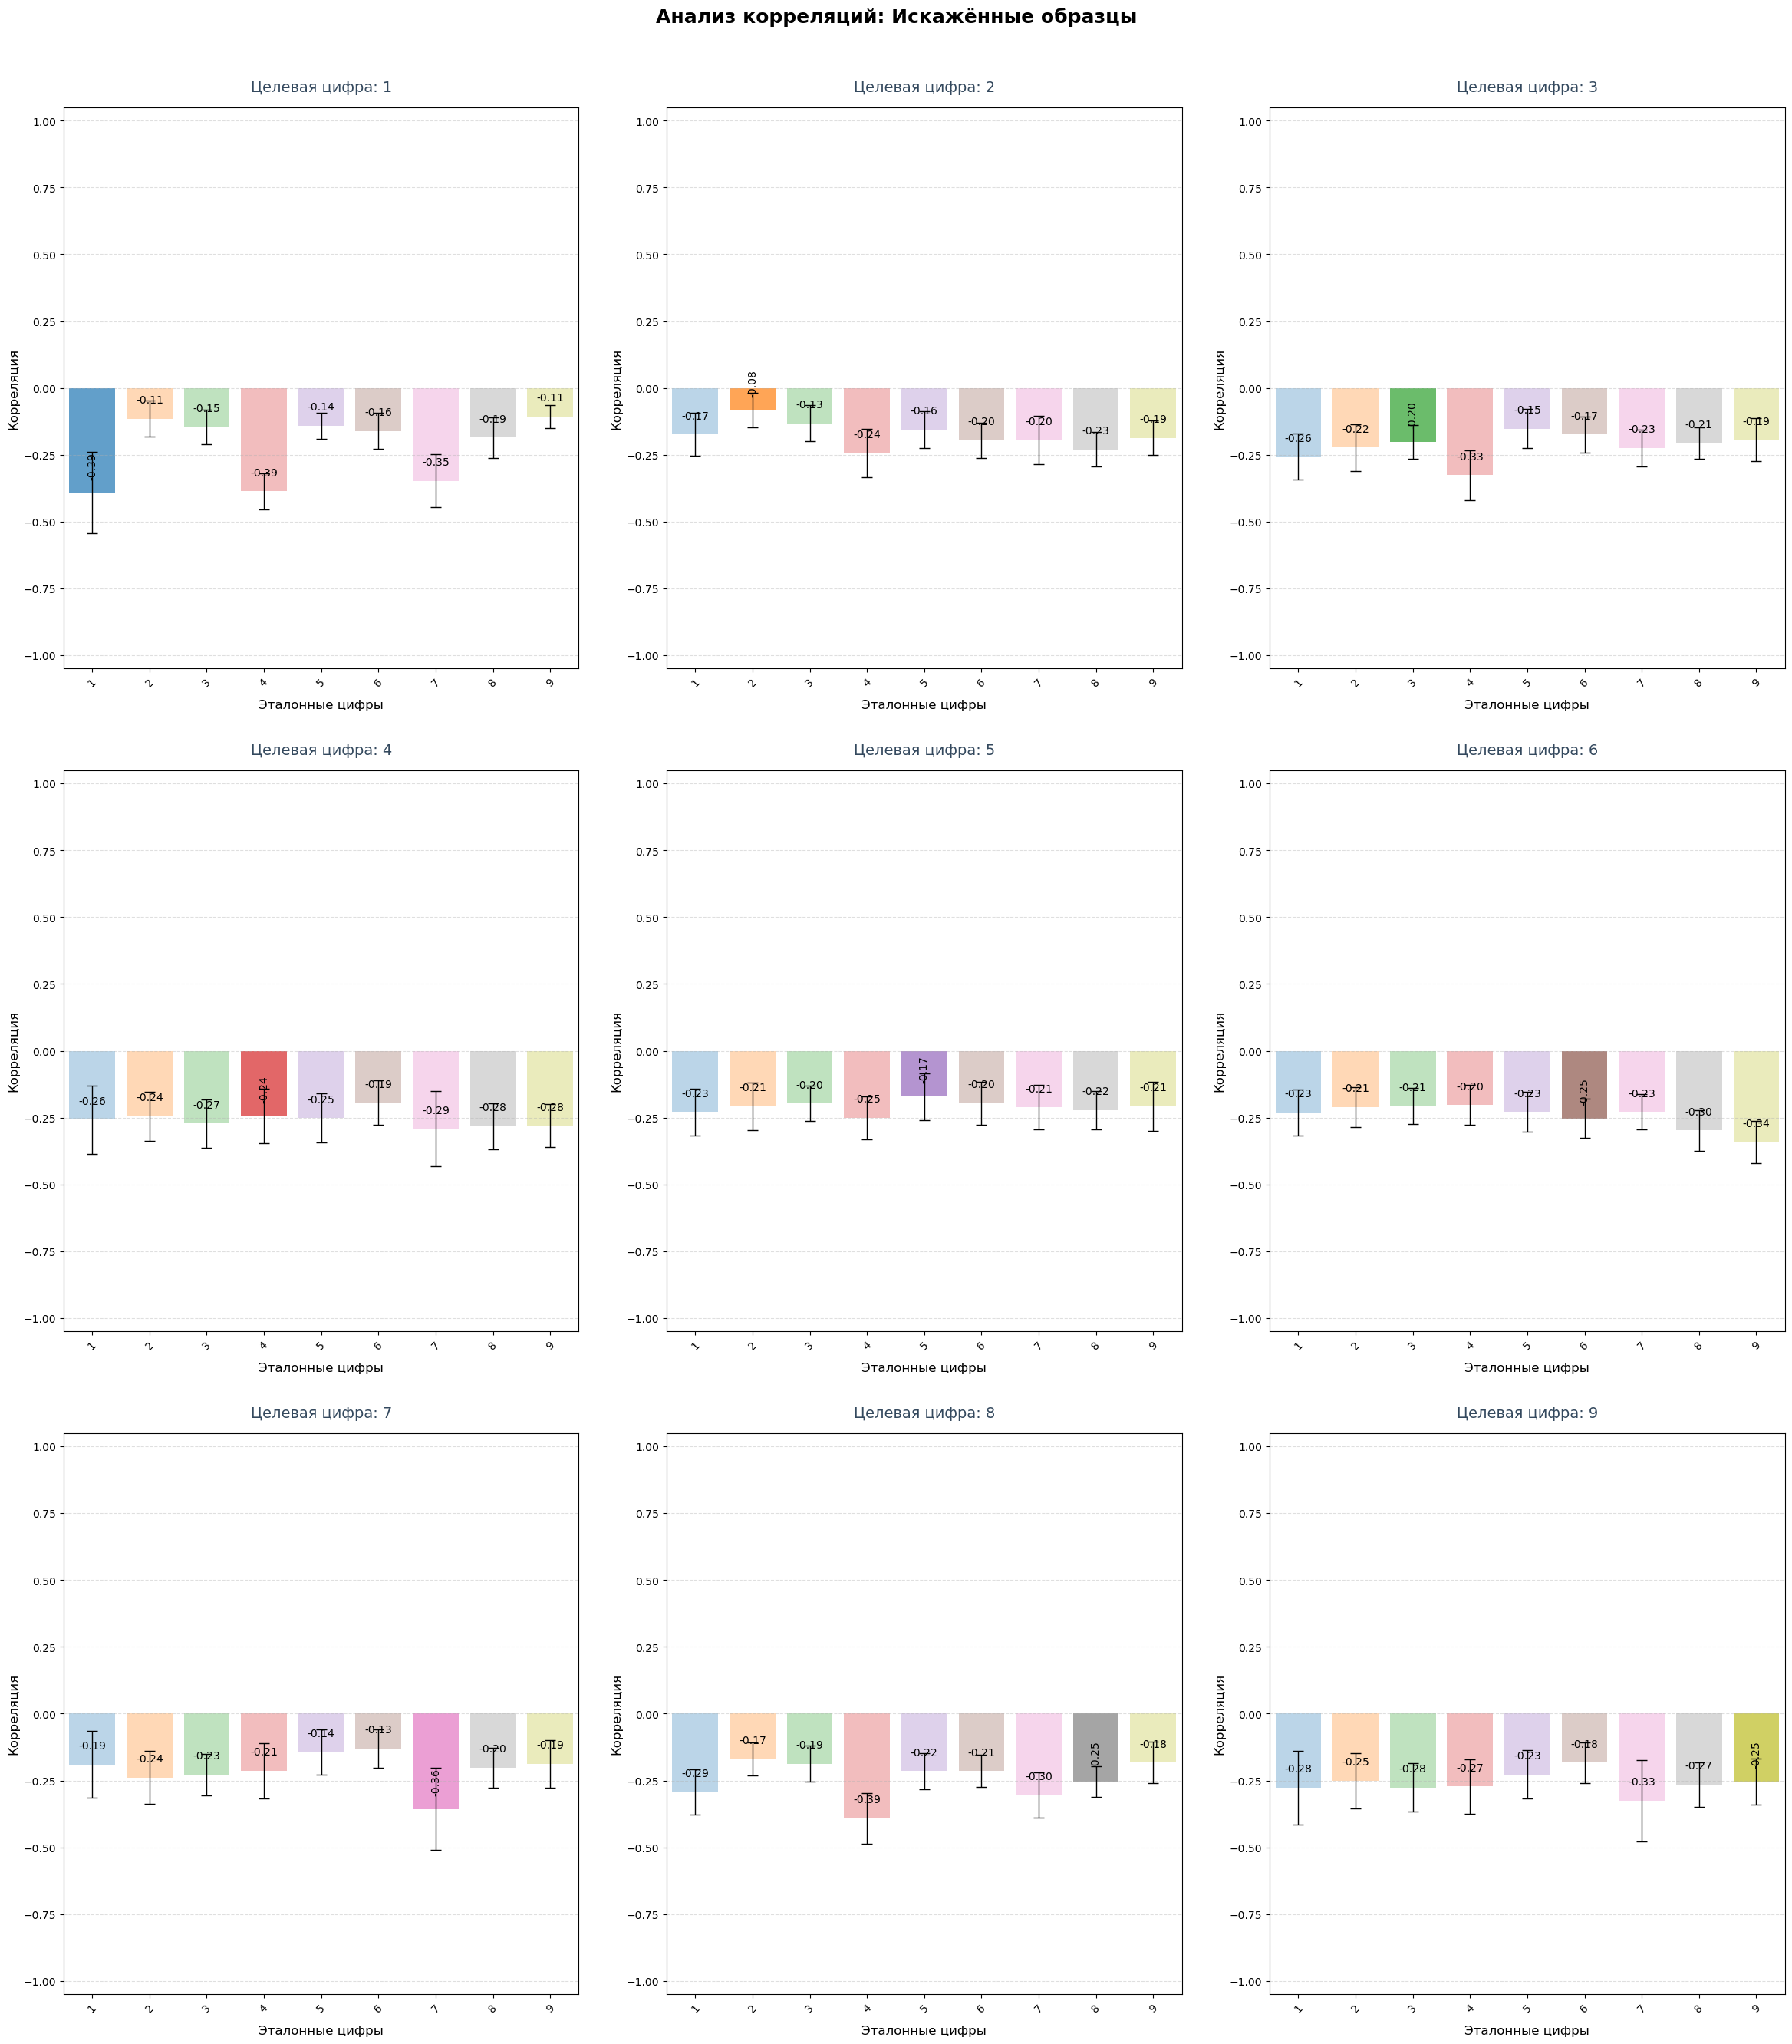

In [30]:
# Конфигурационные параметры
DIGITS = np.arange(1, 10)
DATA_TYPES = {
    0: ('Чистые', '#2ecc71', 'correlation_clean.png'),
    1: ('Зашумленные', '#e67e22', 'correlation_noisy.png'),
    2: ('Искажённые', '#e74c3c', 'correlation_distorted.png')
}
COLORS = plt.cm.tab10.colors

# Создание эталонов с проверкой данных
pure_mask = (types == 0) & np.isin(y, DIGITS)  # Добавлена проверка цифр
references = {d: X[(y == d) & pure_mask].mean(axis=0) for d in DIGITS}

for type_val, (type_name, color, fname) in DATA_TYPES.items():
    plt.figure(figsize=(24, 27))
    plt.suptitle(f'Анализ корреляций: {type_name} образцы', 
                y=0.995, fontsize=18, weight='bold')
    
    for target_digit in DIGITS:
        ax = plt.subplot(3, 3, target_digit)
        samples = X[(y == target_digit) & (types == type_val)]
        
        # Проверка наличия данных
        if len(samples) == 0:
            print(f"Предупреждение: Нет данных для {type_name} цифры {target_digit}")
            continue
        
        # Расчёт корреляций с обработкой исключений
        corrs = {}
        for ref in DIGITS:
            try:
                corrs[ref] = [np.corrcoef(sample, references[ref])[0,1] 
                             for sample in samples]
                # Ограничение корреляций [0, 1]
                corrs[ref] = np.clip(corrs[ref], -1, 1)
            except Exception as e:
                print(f"Ошибка для цифры {target_digit}, эталон {ref}: {str(e)}")
                corrs[ref] = [0]

        # Визуализация
        for ref_digit in DIGITS:
            mean_corr = np.nanmean(corrs.get(ref_digit, [0]))
            std_corr = np.nanstd(corrs.get(ref_digit, [0]))
            
            # Автоматическая регулировка высоты текста
            text_y_pos = mean_corr + 0.05 if mean_corr < 0.9 else mean_corr - 0.1
            bar = ax.bar(ref_digit, mean_corr,
                        color=COLORS[ref_digit-1],
                        alpha=0.7 if ref_digit == target_digit else 0.3,
                        yerr=std_corr,
                        capsize=5,
                        error_kw={'elinewidth': 1})
            
            # Подписи для всех столбцов
            ax.text(ref_digit, text_y_pos,
                   f"{mean_corr:.2f}",
                   ha='center',
                   va='bottom',
                   fontsize=10,
                   color='black',
                   rotation=90 if ref_digit == target_digit else 0)
        
        # Настройка осей с динамическим диапазоном
        ax.set_xlim(0.5, 9.5)
        ax.set_ylim(-1.05, 1.05)  # Расширенный диапазон для текста
        ax.set_xticks(DIGITS)
        ax.set_xticklabels(DIGITS, rotation=45)  # Поворот меток
        ax.set_xlabel('Эталонные цифры', fontsize=12, labelpad=10)
        ax.set_ylabel('Корреляция', fontsize=12)
        ax.set_title(f'Целевая цифра: {target_digit}', fontsize=14, pad=15, color='#34495e')
        ax.grid(axis='y', linestyle='--', alpha=0.4)
    
    plt.tight_layout(pad=3.0)
    plt.savefig(fname, dpi=150, bbox_inches='tight')
    plt.show()


тк искаженные образцы белые на черном фоне, поэтому коэффициенты отрицательные, по этому можно принять, что смена знака будет уместной.

8. Экспорт результатов

In [31]:
# Сохранение метрик
report_df.to_csv('classification_report.csv')

# Сохранение корреляционных данных
corr_data = []
for d in DIGITS:
    for t in [0, 1, 2]:
        mask = (y == d) & (types == t)
        corrs = [np.corrcoef(X[idx], references[d])[0,1] 
                for idx in np.where(mask)[0]]
        for c in corrs:
            corr_data.append({'digit': d, 
                            'type': ['Clean', 'Noisy', 'Distorted'][t],
                            'correlation': c})
            
pd.DataFrame(corr_data).to_csv('correlations.csv', index=False)

print("Все результаты успешно сохранены!")

Все результаты успешно сохранены!
